# Compare Feature Selection Methods and Identify Overlapping Features
### Group 33, Florida Atlantic University
This notebook compares multiple feature selection methods applied to miRNA expression data for lung cancer classification. The goals are to:  
- Identify top-ranked features from each selection method  
- Quantify overlaps and agreement across methods  
- Generate consensus biomarkers based on shared selections  
- Save outputs for use in downstream classification models


> Load Feature Selection Results

In [16]:
from pathlib import Path
import pandas as pd
import logging

# --- Logging Setup ---
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# --- Define Paths ---
RESULTS_DIR = Path("../results")
PROCESSED_DATA = Path("../processed_data/miRNA_stage_subtype.csv")  # Will be used later

# --- Debugging: Confirm Directory Structure ---
print(f"Current working directory: {Path().resolve()}")
print(f"Feature selection results expected at: {RESULTS_DIR.resolve()}")

# --- Check if results directory exists ---
if not RESULTS_DIR.exists():
    logging.warning(f"Results directory not found at: {RESULTS_DIR.resolve()}")

Current working directory: C:\Users\amaba\Documents\School\multiclass_lungcancer_classification_models\feature_selection
Feature selection results expected at: C:\Users\amaba\Documents\School\multiclass_lungcancer_classification_models\results


> File Paths and Feature Loader Function

In [20]:
# --- Feature Selection Result Files ---
file_paths = {
    "fold_change": RESULTS_DIR / "fold_change_results.csv",
    "chi_squared": RESULTS_DIR / "chi_squared_features.csv",
    "information_gain": RESULTS_DIR / "information_gain_results.csv",
    "lasso": RESULTS_DIR / "lasso_results.csv",
    "nca": RESULTS_DIR / "nca_results.csv",
    "rfe": RESULTS_DIR / "recursive_feature_elimination" / "recursive_feature_selection_general.csv"
}

# --- Load Top-K Features From Each Method ---
def load_top_k_features(file_paths, num_features=50):
    feature_sets = {}

    print(f"\nLoading top {num_features} features from each method...\n")

    for key, path in file_paths.items():
        print(f"--- {key.upper()} ---")
        print(f"Checking: {path.as_posix()}")

        if not path.exists():
            logging.warning(f"[{key}] File not found: {path.as_posix()}")
            continue

        df = pd.read_csv(path)
        print(f"Loaded file: {path.name}")
        print(f"Columns found: {list(df.columns)}")

        # Method-specific column handling
        if key == "fold_change" and "log2_fold_change" in df.columns:
            features = df.nlargest(num_features, "log2_fold_change")["Unnamed: 0"]
        elif key == "chi_squared" and "Score" in df.columns:
            features = df.nlargest(num_features, "Score")["Feature"]
        elif key == "information_gain" and "Info_Gain_General" in df.columns:
            features = df.nlargest(num_features, "Info_Gain_General")["Feature"]
        elif key == "lasso" and "Coefficient" in df.columns:
            features = df.nlargest(num_features, "Coefficient")["Feature"]
        elif key in ["nca", "rfe"] and "Feature" in df.columns:
            features = df["Feature"].head(num_features)
        else:
            logging.warning(f"[{key}] Unexpected format or missing expected column.")
            continue

        features_cleaned = features.dropna().astype(str).unique()
        feature_sets[key] = set(features_cleaned)

        print(f"Top {len(features_cleaned)} features loaded from {key}.\n")

    combined = set().union(*feature_sets.values())
    print(f"✓ Total unique features selected across all methods: {len(combined)}\n")

    return feature_sets, combined

# --- Execute Feature Loading ---
feature_sets, top_features = load_top_k_features(file_paths, num_features=50)


Loading top 50 features from each method...

--- FOLD_CHANGE ---
Checking: ../results/fold_change_results.csv
Loaded file: fold_change_results.csv
Columns found: ['Unnamed: 0', 'log2_fold_change', 'absolute_fold_change', 'regulation']
Top 50 features loaded from fold_change.

--- CHI_SQUARED ---
Checking: ../results/chi_squared_features.csv
Loaded file: chi_squared_features.csv
Columns found: ['Feature', 'Score']
Top 50 features loaded from chi_squared.

--- INFORMATION_GAIN ---
Checking: ../results/information_gain_results.csv
Loaded file: information_gain_results.csv
Columns found: ['Feature', 'Info_Gain_General', 'Info_Gain_Stage', 'Info_Gain_Subtype']
Top 50 features loaded from information_gain.

--- LASSO ---
Checking: ../results/lasso_results.csv
Loaded file: lasso_results.csv
Columns found: ['Feature', 'Coefficient']
Top 50 features loaded from lasso.

--- NCA ---
Checking: ../results/nca_results.csv
Loaded file: nca_results.csv
Columns found: ['Feature', 'Importance']
Top 50 

> Feature Inspection & Overlap Calculation

In [21]:
# --- Inspect Features and Overlaps Between Methods ---

print("\n======================")
print("FEATURE SET PREVIEW")
print("======================")

for method, features in feature_sets.items():
    features_list = list(features)
    print(f"\n{method.upper()} — Total Features: {len(features_list)}")
    print(f"Sample Features: {features_list[:5]}")

# --- Format Check ---
print("\n======================")
print("FEATURE FORMAT CHECK")
print("======================")

for method, features in feature_sets.items():
    if features:
        feature = list(features)[0]
        print(f"{method}: {feature} (type: {type(feature)})")
    else:
        print(f"{method}: No features found.")

# --- Pairwise Overlap Calculation ---
print("\n===============================")
print("PAIRWISE FEATURE SET OVERLAP")
print("===============================")

method_keys = sorted(feature_sets.keys())

for i in range(len(method_keys)):
    for j in range(i + 1, len(method_keys)):
        method1, method2 = method_keys[i], method_keys[j]
        set1, set2 = feature_sets[method1], feature_sets[method2]
        overlap = len(set1 & set2)
        union = len(set1 | set2)
        jaccard = (overlap / union) * 100 if union > 0 else 0
        print(f"{method1} ∩ {method2}: {overlap} features ({jaccard:.2f}% Jaccard similarity)")


FEATURE SET PREVIEW

FOLD_CHANGE — Total Features: 50
Sample Features: ['hsa-mir-520a', 'hsa-mir-2117', 'hsa-mir-523', 'hsa-mir-3125', 'hsa-mir-4651']

CHI_SQUARED — Total Features: 50
Sample Features: ['hsa-mir-3665', 'hsa-mir-451b', 'hsa-mir-6719', 'hsa-mir-3972', 'hsa-mir-6127']

INFORMATION_GAIN — Total Features: 50
Sample Features: ['hsa-mir-23c', 'hsa-mir-6849', 'hsa-mir-3145', 'hsa-mir-17', 'hsa-mir-5572']

LASSO — Total Features: 50
Sample Features: ['hsa-mir-3665', 'hsa-mir-451b', 'hsa-mir-3177', 'hsa-mir-582', 'hsa-mir-187']

NCA — Total Features: 50
Sample Features: ['hsa-mir-3665', 'hsa-mir-3972', 'hsa-mir-3672', 'hsa-mir-1285-2', 'hsa-mir-5572']

RFE — Total Features: 50
Sample Features: ['hsa-mir-5094', 'hsa-mir-4661', 'hsa-mir-8085', 'hsa-mir-4733', 'hsa-mir-186']

FEATURE FORMAT CHECK
fold_change: hsa-mir-520a (type: <class 'str'>)
chi_squared: hsa-mir-3665 (type: <class 'str'>)
information_gain: hsa-mir-23c (type: <class 'str'>)
lasso: hsa-mir-3665 (type: <class 'str'

> Find Overlapping Features

In [23]:
from collections import Counter
import pandas as pd
import os

# --- Set Overlap Threshold ---
min_overlap = 3  # Change to 5 or 7 to increase strictness

print("\n==============================")
print(f"BUILDING CONSENSUS BIOMARKER PANEL (≥{min_overlap} METHODS)")
print("==============================")

# --- Count how often each feature appears across all methods ---
feature_counter = Counter()
for method, feature_set in feature_sets.items():
    feature_counter.update(feature_set)
    print(f"{method}: {len(feature_set)} features counted.")

# --- Filter features that meet the minimum overlap threshold ---
overlapping_features = {
    feature for feature, count in feature_counter.items()
    if count >= min_overlap
}

# --- Print results ---
print(f"\nTotal unique features selected across all methods: {len(feature_counter)}")
print(f"Features selected by ≥{min_overlap} methods: {len(overlapping_features)}")
print("Sample consensus features:")
for feature in list(overlapping_features)[:5]:
    print(f" - {feature}")

# --- Save results ---
output_dir = "../results/feature_analysis"
os.makedirs(output_dir, exist_ok=True)

overlap_df = pd.DataFrame({'Feature': sorted(overlapping_features)})
overlap_path = os.path.join(output_dir, "overlapping_features.csv")
overlap_df.to_csv(overlap_path, index=False)

print(f"\nConsensus feature set saved to: {overlap_path}")


BUILDING CONSENSUS BIOMARKER PANEL (≥3 METHODS)
fold_change: 50 features counted.
chi_squared: 50 features counted.
information_gain: 50 features counted.
lasso: 50 features counted.
nca: 50 features counted.
rfe: 50 features counted.

Total unique features selected across all methods: 262
Features selected by ≥3 methods: 7
Sample consensus features:
 - hsa-mir-3665
 - hsa-mir-4440
 - hsa-mir-4264
 - hsa-mir-3688-1
 - hsa-mir-548c

Consensus feature set saved to: ../results/feature_analysis\overlapping_features.csv


> Filtering Processed Data for Overlapping Features

In [24]:
import pandas as pd
import numpy as np
import logging
import os

# --- Load Full Dataset ---
processed_data_path = '../processed_data/miRNA_stage_subtype.csv'
print(f"\nLoading dataset from: {processed_data_path}")
processed_data = pd.read_csv(processed_data_path)

# --- Validate Overlapping Feature Set ---
if not overlapping_features:
    raise ValueError("No overlapping features found. Please verify previous steps.")

overlapping_feature_list = list(overlapping_features)

# --- Target Label Info (Stage) ---
print("\nTarget variable (stage) distribution BEFORE filtering:")
print(processed_data['stage'].value_counts())

# --- Identify Missing Features ---
missing_features = [f for f in overlapping_feature_list if f not in processed_data.columns]
if missing_features:
    logging.warning(f"Missing features in dataset: {missing_features}")

# --- Keep Only Features Present in Dataset ---
available_features = [f for f in overlapping_feature_list if f in processed_data.columns]
expression_values = processed_data[available_features]
y = processed_data['stage']

# --- Missing Data Summary ---
print("\nMissing Value Summary:")
print(f"- Total samples: {len(processed_data)}")
print(f"- Features used: {len(available_features)}")
print(f"- Features with missing values: {expression_values.isnull().any().sum()}")
print(f"- Samples with missing values: {expression_values.isnull().any(axis=1).sum()}")

# --- Drop Samples with Any Missing Data ---
if expression_values.isnull().values.any() or y.isnull().values.any():
    logging.warning("Dropping rows with missing expression or labels.")
    valid_indices = ~expression_values.isnull().any(axis=1) & ~y.isnull()
    expression_values = expression_values[valid_indices]
    y = y[valid_indices]

# --- Final Dataset Shape ---
print("\nFinal dataset dimensions AFTER filtering:")
print(f"- Expression matrix: {expression_values.shape}")
print(f"- Target labels:     {y.shape}")

print("\nTarget variable (stage) distribution AFTER filtering:")
print(y.value_counts())

# --- Summary Statistics for Expression Values ---
print("\nSummary statistics for selected features:")
print(expression_values.describe().transpose())

# --- Correlation Analysis (Optional Redundancy Check) ---
print("\nHighly correlated feature pairs (Pearson |r| > 0.9):")
corr_matrix = expression_values.corr()
high_corr = np.where(np.abs(corr_matrix) > 0.9)
high_corr_pairs = [
    (available_features[i], available_features[j], corr_matrix.iloc[i, j])
    for i, j in zip(*high_corr) if i < j
]

for feat1, feat2, corr in high_corr_pairs[:5]:
    print(f"{feat1} — {feat2}: r = {corr:.3f}")

# --- Save Final Filtered Dataset ---
output_dir = "../results/filtered_data"
os.makedirs(output_dir, exist_ok=True)

filtered_df = expression_values.copy()
filtered_df["stage"] = y
filtered_path = os.path.join(output_dir, "filtered_miRNA_stage_data.csv")
filtered_df.to_csv(filtered_path, index=False)

print(f"\nFiltered dataset saved to: {filtered_path}")


Loading dataset from: ../processed_data/miRNA_stage_subtype.csv

Target variable (stage) distribution BEFORE filtering:
stage
1    566
2    308
3    175
4     31
0     11
Name: count, dtype: int64

Missing Value Summary:
- Total samples: 1091
- Features used: 7
- Features with missing values: 0
- Samples with missing values: 0

Final dataset dimensions AFTER filtering:
- Expression matrix: (1091, 7)
- Target labels:     (1091,)

Target variable (stage) distribution AFTER filtering:
stage
1    566
2    308
3    175
4     31
0     11
Name: count, dtype: int64

Summary statistics for selected features:
                 count      mean       std  min  25%  50%  75%       max
hsa-mir-3665    1091.0  0.000171  0.005659  0.0  0.0  0.0  0.0  0.186910
hsa-mir-4440    1091.0  0.000190  0.006284  0.0  0.0  0.0  0.0  0.207562
hsa-mir-4264    1091.0  0.000158  0.005202  0.0  0.0  0.0  0.0  0.171833
hsa-mir-3688-1  1091.0  0.041474  0.120259  0.0  0.0  0.0  0.0  1.305125
hsa-mir-548c    1091.0  0.0

> UpSet Plot: Global Overlap


Generating UpSet plot...
✓ UpSet plot saved to: ../results/filtered_data\global_feature_overlap_upset.png


<Figure size 1200x800 with 0 Axes>

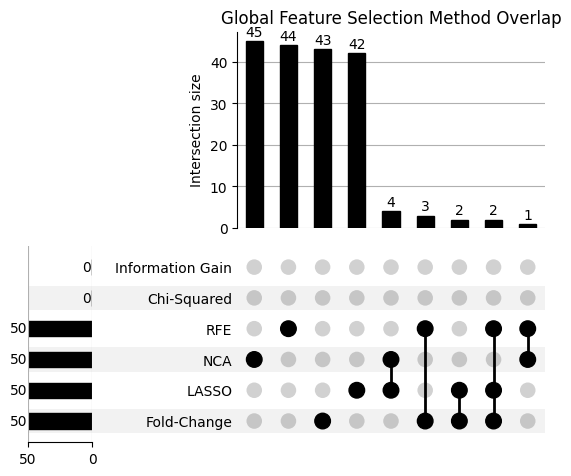

In [ ]:
# --- Create UpSet Plot ---
print("\nGenerating UpSet plot...")

all_features = set.union(*venn_sets.values())
upset_data = [
    {method: int(feature in features) for method, features in venn_sets.items()}
    for feature in all_features
]
df_upset = pd.DataFrame(upset_data)
combo_counts = df_upset.value_counts()

plt.figure(figsize=(12, 8))
plot(combo_counts, sort_by='cardinality', show_counts=True)
plt.title("Global Feature Selection Method Overlap")
upset_path = os.path.join(output_dir, "global_feature_overlap_upset.png")
plt.savefig(upset_path, bbox_inches='tight', dpi=300)
print(f"UpSet plot saved to: {upset_path}")
plt.show()


### Top Overlapping miRNAs

In [10]:
import os
import pandas as pd
import logging
from collections import Counter

# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define input/output paths
RESULTS_DIR = "../results"
output_dir = os.path.join(RESULTS_DIR, "feature_analysis")
os.makedirs(output_dir, exist_ok=True)

# Define feature selection result files
feature_files = {
    "fold_change": os.path.join(RESULTS_DIR, "fold_change_results.csv"),
    "chi2": os.path.join(RESULTS_DIR, "chi_squared_features.csv"),
    "info_gain": os.path.join(RESULTS_DIR, "information_gain_results.csv"),
    "lasso": os.path.join(RESULTS_DIR, "lasso_results.csv"),
    "rfe": os.path.join(RESULTS_DIR, "recursive_feature_elimination", "recursive_feature_selection_general.csv"),
    "nca": os.path.join(RESULTS_DIR, "nca_results.csv"),
    "random_forest": os.path.join(RESULTS_DIR, "random_forest_results.csv"),
    # "vtfs": os.path.join(RESULTS_DIR, "vtfs_features.csv")  # Add later if needed
}

# Smart loader for features from CSVs
def load_features(file_path):
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        for col in ["Feature", "Unnamed: 0", "miRNA_ID"]:
            if col in df.columns:
                features = set(df[col].dropna().astype(str))
                logging.info(f"{file_path} → Loaded {len(features)} features")
                return features
        logging.warning(f"No valid column found in: {file_path}")
    else:
        logging.warning(f"File not found: {file_path}")
    return set()

# Load all feature sets
feature_sets = {method: load_features(path) for method, path in feature_files.items()}

# Count miRNA frequency across all methods
all_features = [feature for feature_list in feature_sets.values() for feature in feature_list]
feature_counts = Counter(all_features)

# Filter miRNAs found in >= N methods
min_methods = 5
top_overlap = {feature: count for feature, count in feature_counts.items() if count >= min_methods}

# Convert to DataFrame
miRNA_occurrences_df = pd.DataFrame.from_dict(feature_counts, orient="index", columns=["Frequency"])
miRNA_occurrences_df = miRNA_occurrences_df.sort_values(by="Frequency", ascending=False)

top_overlap_df = pd.DataFrame.from_dict(top_overlap, orient="index", columns=["Frequency"])
top_overlap_df = top_overlap_df.sort_values(by="Frequency", ascending=False)

# Save outputs
miRNA_occurrences_df.to_csv(os.path.join(output_dir, "miRNA_occurrences.csv"))
top_overlap_df.to_csv(os.path.join(output_dir, "top_overlapping_miRNAs.csv"))

# Console preview
print(f"\nmiRNA frequency table saved to: {output_dir}/miRNA_occurrences.csv")
print(f"Top overlapping miRNAs (≥{min_methods} methods) saved to: {output_dir}/top_overlapping_miRNAs.csv")

if not top_overlap_df.empty:
    print("\nTop Overlapping miRNAs (up to 20 shown):")
    print(top_overlap_df.head(20))
else:
    print("\nNo miRNAs found in ≥{min_methods} methods.")

2025-03-28 16:43:36,926 - INFO - ../results\fold_change_results.csv → Loaded 1883 features
2025-03-28 16:43:36,930 - INFO - ../results\chi_squared_features.csv → Loaded 1637 features
2025-03-28 16:43:36,936 - INFO - ../results\information_gain_results.csv → Loaded 1881 features
2025-03-28 16:43:36,939 - INFO - ../results\lasso_results.csv → Loaded 503 features
2025-03-28 16:43:36,941 - INFO - ../results\recursive_feature_elimination\recursive_feature_selection_general.csv → Loaded 50 features
2025-03-28 16:43:36,947 - INFO - ../results\nca_results.csv → Loaded 1870 features
2025-03-28 16:43:36,952 - INFO - ../results\random_forest_results.csv → Loaded 1881 features



miRNA frequency table saved to: ../results\feature_analysis/miRNA_occurrences.csv
Top overlapping miRNAs (≥5 methods) saved to: ../results\feature_analysis/top_overlapping_miRNAs.csv

Top Overlapping miRNAs (up to 20 shown):
                Frequency
hsa-mir-3175            7
hsa-mir-3907            7
hsa-mir-7111            7
hsa-mir-6811            7
hsa-mir-181b-1          7
hsa-mir-6872            7
hsa-mir-571             7
hsa-mir-4434            7
hsa-mir-6888            7
hsa-mir-3688-1          7
hsa-mir-3125            7
hsa-mir-6507            7
hsa-mir-4747            7
hsa-mir-2355            7
hsa-mir-597             7
hsa-mir-3199-1          7
hsa-mir-4284            7
hsa-mir-425             7
hsa-mir-7843            7
hsa-mir-4435-2          7
